In [1]:
import numpy as np
from qiskit.quantum_info.operators.symplectic import SparsePauliOp
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
from scipy import optimize
from qiskit.visualization import plot_histogram
from bitstring import BitArray
from collections import Counter
import copy
import wojciech_remastered as wo
from skquant import opt

In [2]:
def bin_to_pattern(x):
    return [ [1-int(i), int(i)] for i in x ]

In [3]:
def all_config(size):
    all_pat = []
    for i in range(size-1):
        for j in range(size-1-i):
            for v1 in range(2):
                for v2 in range(2):
                    all_pat.append( [[1,1]]*i + bin_to_pattern(str(v1)) + [[1,1]]*j + bin_to_pattern(str(v2)) + [[1,1]]*(size-i-j-2))
    return all_pat

In [4]:
def create_specific_patterns(mode1,mode2,size):
    pats =[]
    for i in range(2):
        for j in range(2):
            pats.append( [[1,1]]*mode1 + bin_to_pattern(str(i)) + [[1,1]]*(mode2-mode1-1) + bin_to_pattern(str(j)) + [[1,1]]*(size-mode1-(mode2-mode1-1)-2) )
    return pats

In [5]:
def create_specific_patterns3(mode1,mode2,mode3,size):
    pats =[]
    for i in range(2):
        for j in range(2):
            for k in range(2):
                pats.append( [[1,1]]*mode1 + bin_to_pattern(str(i)) + [[1,1]]*(mode2-mode1-1) + bin_to_pattern(str(j)) + [[1,1]]*(mode3-(mode2-mode1-1)-mode1-2) + bin_to_pattern(str(k)) + [[1,1]]*(size -mode1-(mode2-mode1-1)-(mode3-(mode2-mode1-1)-mode1-2)-3) )
    return pats

In [6]:
def create_specific_patterns4(mode1,mode2,mode3,mode4,size):
    pats = []
    temp_pats = create_specific_patterns3(mode1,mode2,mode3,size)
    for p in temp_pats:
        for k in range(2):
            p_prime = copy.deepcopy(p)
            p_prime[mode4] = bin_to_pattern(str(k))[0]
            pats.append(p_prime)
    return pats
# create_specific_patterns4(0,1,2,4,N)

In [7]:
def overlapp(x,measurement):
    return np.prod( [np.dot(p1,p2) for p1,p2 in zip(x,measurement)] )

In [8]:
def dev_pattern(pat):
    f = np.array([1])
    for i in pat:
        f = np.kron(f,i)
    return f

In [9]:
def compute_hamiltonian(all_pat,y):

    H = 0

    for p,yi in zip(all_pat,y):

        if yi==0:
            continue
        
        ops = []
        for t in p:
            if t == [0,1]:
                coefs = [1/2,-1/2]
            elif t == [1,0]:
                coefs = [1/2,1/2]
            else:
                coefs = [1,0]
            ops.append(SparsePauliOp(["I","Z"],coefs))
        op = ops[0]
        for i in range(1,len(ops)):
            op = op.tensor(ops[i]).simplify()
        H = (H + (op * yi[0])).simplify()

    # H = H.simplify(atol=1, rtol=0)

    return np.real_if_close(H.coeffs),H.paulis

# H,paulis_idx = compute_hamiltonian(all_pat,y)
# for pstring,coef in zip(paulis_idx,H):
#     print(pstring,coef)

In [10]:
def paulis_to_gates(pauli_string):
    return [i for i,s in enumerate(pauli_string) if s=='Z']

In [11]:
def obj_func(z):
    v = BitArray(bin='0'+z).int
    return (A.T[v] * y)[0,0]


def compute_expectation(counts):
        
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = -obj_func(bitstring)
        avg += obj * count
        sum_count += count
    # print(avg/sum_count)    
    return avg/sum_count

def create_qaoa_circ(theta,paulis_idx,H):

    nqubits = N
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)

        for pstring,coef in zip(paulis_idx,H):
            if coef!=0:
                idx = paulis_to_gates(str(pstring))
                if len(idx)==1:
                    qc.rz(2*gamma[irep]*coef,idx[0])
                elif len(idx)==2:
                    qc.rzz(2*gamma[irep]*coef,idx[0],idx[1])
                elif len(idx)==3:
                    qc.cnot(idx[0],idx[1])
                    qc.cnot(idx[1],idx[2])
                    qc.rz(2*gamma[irep]*coef,idx[2])
                    qc.cnot(idx[1],idx[2])
                    qc.cnot(idx[0],idx[1])
                elif len(idx)==4:
                    qc.cnot(idx[0],idx[1])
                    qc.cnot(idx[1],idx[2])
                    qc.cnot(idx[2],idx[3])
                    qc.rz(2*gamma[irep]*coef,idx[3])
                    qc.cnot(idx[2],idx[3])
                    qc.cnot(idx[1],idx[2])
                    qc.cnot(idx[0],idx[1])

    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(paulis_idx,H,shots=512):
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(theta,paulis_idx,H)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts)
    
    return execute_circ

In [12]:
def matching_pursuit(y,A):

    x_recov = {}
    r = copy.deepcopy(y)

    for i in range(s):

        v = np.argmax(A.T * r)

        x_recov[v] = (A.T[v]*r)[0,0] if (v not in x_recov) else x_recov[v]+(A.T[v]*r)[0,0]
        r -= (0.05*((A.T[v]*r)[0,0]) * A.T[v]).T

    return x_recov

def matching_pursuit2(y,A,st,itnum):
#Return x st y=Ax

    #Matching Pursuit, initialization
    r = copy.deepcopy(y)   
    x = []

    for _ in range(itnum):
        
        #Find max
        t = np.argmax(A.T * r)

        #Update
        r -= st * A.T[t].T
        x.append(t)
    
    return np.array([[it[0],it[1]*st] for it in Counter(x).items()])

Number of qubit needed: 8


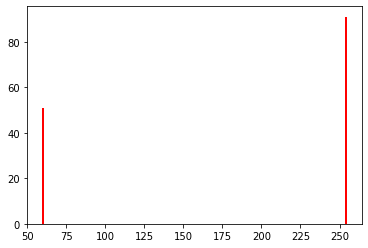

[60, 254]


In [18]:
# m = 5                       #Number of modes
# a = 3                       #Number of possible values
# N = int(np.log2(a**m))+1    #Number of qubits for encoding

N = 8

s = 2                       #Sparsity
print("Number of qubit needed:",N)

#Random sparse spectrum
spec = np.arange(2**N)
np.random.shuffle(spec)
spec = list(spec[:s])
spec.sort()
spec_val = np.random.randint(50,100,s)

bin_spec = []
for x in spec:
    bin_x = "{0:b}".format(x)
    bin_spec.append('0'*(N-len(bin_x)) + bin_x)

plt.bar(spec,spec_val,width=1,color='r')
plt.show()
print(spec)

In [19]:
pat_spec = [bin_to_pattern(bin_x) for bin_x in bin_spec] 

#Nearest Neighboor
all_pat = []
for i in range(N-1):
    all_pat += create_specific_patterns(i,i+1,N)

y = np.zeros((len(all_pat),1))
for pat,val in zip(pat_spec,spec_val):
    y += np.matrix([overlapp(pat,p)*val for p in all_pat]).T

A = np.matrix([ dev_pattern(p) for p in all_pat])

#Additional patterns
l = np.arange(0,N)
all_pat = []
for i in range(10):
    np.random.shuffle(l)
    r = l[0:4]
    r.sort()
    all_pat += create_specific_patterns4(r[0],r[1],r[2],r[3],N)
    print(r[0],r[1],r[2],r[3])

y_additional = np.zeros((len(all_pat),1))
for pat,val in zip(pat_spec,spec_val):
    y_additional += np.matrix([overlapp(pat,p)*val for p in all_pat]).T

A_additional = np.matrix([ dev_pattern(p) for p in all_pat])

0 3 6 7
0 1 3 6
0 1 2 7
1 2 4 5
1 4 5 6
0 5 6 7
3 4 5 6
1 3 6 7
2 3 4 6
1 2 4 5


[[254  70]
 [ 60  30]]


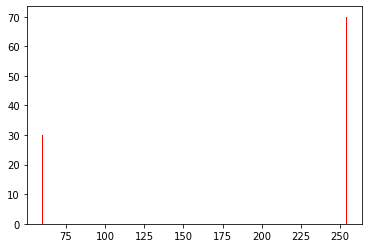

[[254  70]
 [ 60  30]]


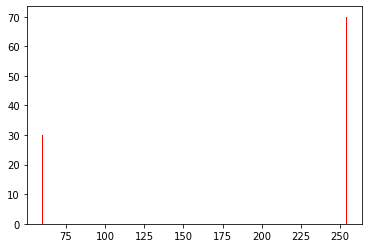

In [20]:
st = 1  #step
itnum = 100 #number of iterations

x_recov = matching_pursuit2(y,A,st,itnum)
print(x_recov)
plt.bar(x_recov[:,0],x_recov[:,1],width=0.5,color='r')
plt.show()

x_recov = matching_pursuit2(y_additional,A_additional,st,itnum)
print(x_recov)
plt.bar(x_recov[:,0],x_recov[:,1],width=0.5,color='r')
plt.show()

[[254  50]
 [188  20]
 [190  20]
 [252  10]]


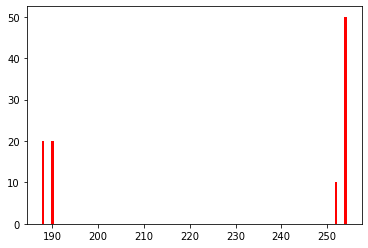

In [21]:
x_recov = wo.Matchpurising(y[:,0],st,itnum,N,2,2)
print(x_recov)
plt.bar(x_recov[:,0],x_recov[:,1],width=0.5,color='r')
plt.show()

In [31]:


def matching_pursuit_QAOA(y,A,st,itnum):
#Return x st y=Ax

    #Matching Pursuit, initialization
    r = copy.deepcopy(y)   
    x = []

    for _ in range(itnum):
        
        #Find max
        H, paulis_idx = compute_hamiltonian(all_pat,r)
        expectation = get_expectation(paulis_idx,H)
        res = opt.minimize(expectation, np.ones(nb_params), bounds, 100, method='imfil')[0]
        backend = Aer.get_backend('aer_simulator')
        backend.shots = 512
        qc_res = create_qaoa_circ(res.optpar,paulis_idx,H)
        counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
        z = list(counts.keys())[np.argmax(list(counts.values()))]
        t = BitArray(bin='0'+z).int
        print(t)

        #Update
        r -= st * A.T[t].T
        x.append(t)
    
    return np.array([[it[0],it[1]*st] for it in Counter(x).items()])

st = 1  #step
itnum = 100 #number of iterations

nb_params = 20
bounds = np.array([[-np.pi, np.pi]]*nb_params, dtype=float)

x_recov = matching_pursuit_QAOA(y,A,st,itnum)
print(x_recov)
plt.bar(x_recov[:,0],x_recov[:,1],width=0.5,color='r')
plt.show()

64
194
82
134
8
67
74
200
138
210
72
138
80
136
58
194
192
130
88
80
41
168
71
76
129
194
147
136
78
75
138


KeyboardInterrupt: 

In [24]:
def matching_pursuit_QAOA(y,A,itnum,possible_s):
#Return x st y=Ax

    #Matching Pursuit, initialization
    r = copy.deepcopy(y)   
    x = []

    #Find max
    H, paulis_idx = compute_hamiltonian(all_pat,r)
    expectation = get_expectation(paulis_idx,H)
    res = opt.minimize(expectation, np.ones(nb_params), bounds, 100, method='imfil')[0]
    backend = Aer.get_backend('aer_simulator')
    backend.shots = 512
    qc_res = create_qaoa_circ(res.optpar,paulis_idx,H)
    counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
    z = list(counts.keys())[np.argmax(list(counts.values()))]
    t = BitArray(bin='0'+z).int
    print(t)

    good_t = t

    for _ in range(itnum-1):

        x.append(good_t)
        t_values = []

        for s in possible_s:
                
            r_prime = np.array(r - (s * A.T[good_t].T))
            H, paulis_idx = compute_hamiltonian(all_pat,r_prime)
            expectation = get_expectation(paulis_idx,H)
            res = opt.minimize(expectation, np.ones(nb_params), bounds, 100, method='imfil')[0]
            backend = Aer.get_backend('aer_simulator')
            backend.shots = 512
            qc_res = create_qaoa_circ(res.optpar,paulis_idx,H)
            counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
            z = list(counts.keys())[np.argmax(list(counts.values()))]
            t = BitArray(bin='0'+z).int
            t_values.append(t)
            
        print(t_values)

        #Find best column
        c = Counter(t_values)
        good_t = max(c, key=c.get)
        print(good_t)

        #Find best step
        t_values = np.array(t_values)
        good_s = possible_s[np.where(t_values==good_t)]
        good_s = np.max(good_s)
        
        #Update
        r -= good_s * A.T[good_t].T
        

    #Last Update
    x.append(good_t)
    
    return np.array([[it[0],it[1]*st] for it in Counter(x).items()])

itnum = 5 #number of iterations

nb_params = 20
bounds = np.array([[-np.pi, np.pi]]*nb_params, dtype=float)
possible_s = np.arange(0.25,2,0.25)
print(possible_s)

x_recov = matching_pursuit_QAOA(y_additional,A_additional,itnum,possible_s)
print(x_recov)
plt.bar(x_recov[:,0],x_recov[:,1],width=0.5,color='r')
plt.show()


[0.25 0.5  0.75 1.   1.25 1.5  1.75]


NameError: name 'opt' is not defined

In [22]:
def matching_pursuit_QAOA(y,A,itnum,possible_s):
#Return x st y=Ax

    #Matching Pursuit, initialization
    r = copy.deepcopy(y)   
    x = []

    #Find max
    H, paulis_idx = compute_hamiltonian(all_pat,r)
    expectation = get_expectation(paulis_idx,H)
    res = optimize.minimize(expectation,np.ones(nb_params),method='COBYLA')
    backend = Aer.get_backend('aer_simulator')
    backend.shots = 512
    qc_res = create_qaoa_circ(res.x,paulis_idx,H)
    counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
    z = list(counts.keys())[np.argmax(list(counts.values()))]
    t = BitArray(bin='0'+z).int
    print(t)

    good_t = t

    for _ in range(itnum-1):

        x.append(good_t)
        t_values = []

        for s in possible_s:
                
            r_prime = np.array(r - (s * A.T[good_t].T))
            H, paulis_idx = compute_hamiltonian(all_pat,r_prime)
            expectation = get_expectation(paulis_idx,H)
            res = optimize.minimize(expectation,np.ones(nb_params),method='COBYLA')
            backend = Aer.get_backend('aer_simulator')
            backend.shots = 512
            qc_res = create_qaoa_circ(res.x,paulis_idx,H)
            counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
            z = list(counts.keys())[np.argmax(list(counts.values()))]
            t = BitArray(bin='0'+z).int
            t_values.append(t)
            
        print(t_values)

        #Find best column
        c = Counter(t_values)
        good_t = max(c, key=c.get)
        print(good_t)

        #Find best step
        t_values = np.array(t_values)
        good_s = possible_s[np.where(t_values==good_t)]
        good_s = np.max(good_s)
        
        #Update
        r -= good_s * A.T[good_t].T
        

    #Last Update
    x.append(good_t)
    
    return np.array([[it[0],it[1]*st] for it in Counter(x).items()])

itnum = 5 #number of iterations

nb_params = 20
bounds = np.array([[-np.pi, np.pi]]*nb_params, dtype=float)
possible_s = np.arange(0.25,2,0.25)
print(possible_s)

x_recov = matching_pursuit_QAOA(y_additional,A_additional,itnum,possible_s)
print(x_recov)
plt.bar(x_recov[:,0],x_recov[:,1],width=0.5,color='r')
plt.show()


[0.25 0.5  0.75 1.   1.25 1.5  1.75]
58


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 